# AI E-band Model_LSTM_96_24

## Many to One Architecture, used to make 24h classification from 15min periods

Glenn Landgren
https://www.linkedin.com/in/glenn-landgren/



## 1. Imports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
# Set default fig size
plt.rcParams["figure.figsize"] = [8, 8]

import sklearn

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Permute
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import Bidirectional

## 2. Get train data

In [2]:
eband_dataset = pd.read_csv("eband_dataset_for_ai_model_2020-10-07/eband_dataset.csv")
eband_dataset.dtypes

C:\Users\glenn\Anaconda3\envs\tf2-gpu-new\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


NeAlias                    object
HalfBPSK_Strong           float64
HalfBPSK                  float64
HalfBPSK_Light            float64
BPSK_Strong               float64
BPSK                      float64
BPSK_Light                float64
QAM4_Strong               float64
QAM4                      float64
QAM4_Light                float64
QAM16_Strong              float64
QAM16                     float64
QAM16_Light               float64
QAM32_Strong              float64
QAM32                     float64
QAM32_Light               float64
QAM64_Strong              float64
QAM64                     float64
QAM64_Light               float64
QAM128_Strong             float64
QAM128                    float64
QAM128_Light              float64
QAM256_Strong             float64
QAM256                    float64
QAM256_Light              float64
QAM512_Strong             float64
QAM512                    float64
QAM512_Light              float64
ModChanges_x              float64
ES_x          

### 2.1 ** Remove classes we do not want to use, i.e. not enough train examples **

In [3]:
print(eband_dataset.shape)
# Remove class 6
eband_dataset = eband_dataset.loc[eband_dataset["Y_24h"] != 6]
print(eband_dataset.shape)
# Remove class 4
eband_dataset = eband_dataset.loc[eband_dataset["Y_24h"] != 4]
print(eband_dataset.shape)

(77952, 50)
(76800, 50)
(72768, 50)


### 2.2 Visualize data
Note, only basic visualization is shown here

### 2.2.1 Class disribution

In [4]:
# unique labels
eband_dataset["Y_24h"].unique()

array([ 5,  2,  9,  3, 11,  1,  0, 10,  8,  7, 12, 14], dtype=int64)

Number of training examples:  752


,NeAlias,Y_24h,Num_train_examples,For validation/ test (80/20)
Y_24h_text,,,,
0. OK,11712,0,122,24.4
1. Unstable Antenna.,12576,1,131,26.2
2. Wet Snow.,9216,2,96,19.2
3. Affected by Rain.,11808,3,123,24.6
5. Serious LOS or Alignment problem.,6240,5,65,13.0
7. Stuck on low modulation.,1632,7,17,3.4
8. Equipment problem.,5088,8,53,10.6
9. Out of service detected.,3264,9,34,6.8
10. Limited data.,3744,10,39,7.8


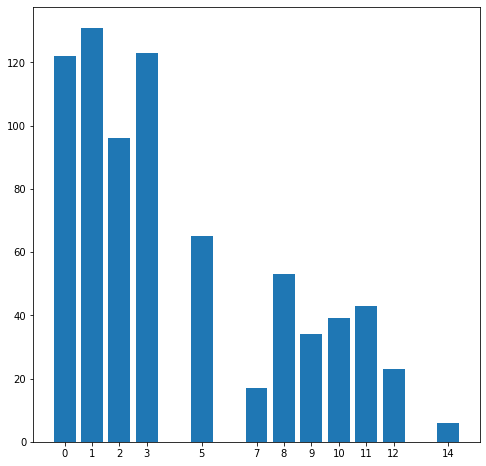

In [5]:
def class_distr_24_h(input_df):

    df = input_df.groupby(["Y_24h_text"]).agg({"NeAlias": "count", "Y_24h": "mean"})

    df["Num_train_examples"] =  df["NeAlias"]//96
    df["For validation/ test (80/20)"] =  df["Num_train_examples"]*0.2
    df.sort_values(by="Y_24h", inplace=True)
    #df.set_index("Y_24h_text", inplace=True)
    
    plt.bar(df["Y_24h"], df["Num_train_examples"], tick_label=df["Y_24h"])
    return df

view_class_distr_24h = class_distr_24_h(eband_dataset)
print("Number of training examples: ", view_class_distr_24h["Num_train_examples"].sum())
view_class_distr_24h

### 2.2.2 Heatmap, Features vs. Label

Here you can modify function to view any features you would like

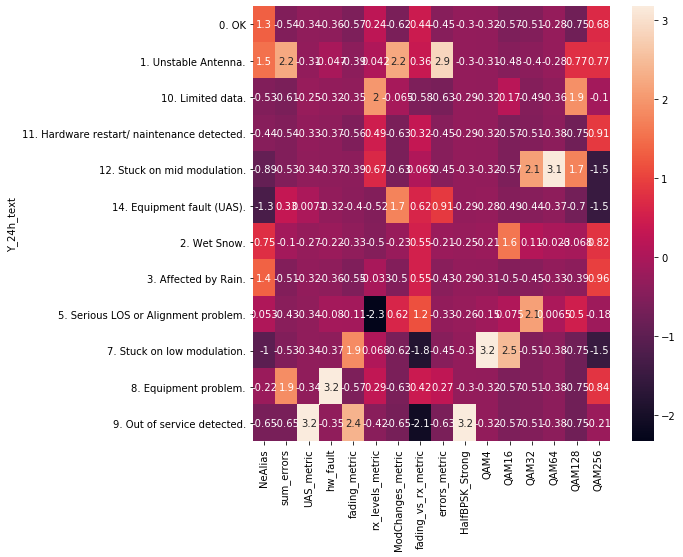

In [6]:
def heatmap_24h_class(df):
    df = df.groupby(["Y_24h_text"]).agg({ "NeAlias": "count","sum_errors":"mean", "UAS_metric": "mean",
                                        "hw_fault": "mean", "fading_metric": "mean", 'rx_levels_metric':"mean",
                                        "ModChanges_metric": "mean", "fading_vs_rx_metric" : "mean", "errors_metric":"mean",
                                         "UAS_metric" : "mean", 'HalfBPSK_Strong' : "mean", 'QAM4': "mean", "QAM16": "mean",
                                         "QAM32": "mean", 'QAM64': "mean", 'QAM128': "mean", 'QAM256': "mean", 
                                       })

    # Normalize by column
    df=(df-df.mean())/df.std()
    return df

heatmap_24h_class = heatmap_24h_class(eband_dataset)

heat_map = sb.heatmap(heatmap_24h_class , annot=True)
plt.show()

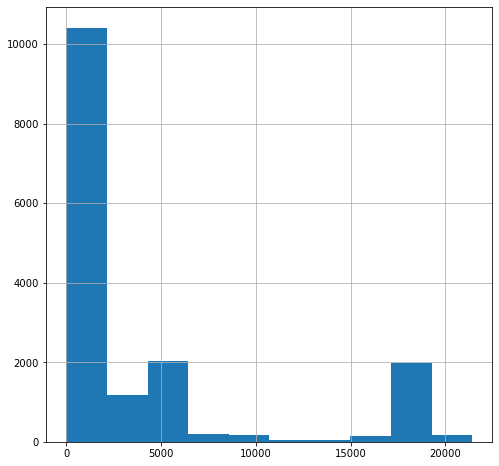

In [7]:
# Select specific features you would like to see  histograms or density plots for 
fading_metric = eband_dataset["fading_metric"].loc[eband_dataset["fading_metric"] > 1]
fading_metric.hist()

## 3. Prepare Dataset, X and Y

- X is the matrix of features
- Y is a vector of labels (for each train example)


### 3.1  X_temp
- Each row
    - ACM modulation in second
    - Mod changes
    - ES,SES, UAS
    - Rx
    - Far-End ES,SES, UAS
    - Far-End Rx
    - Far-End Mod changes

In [8]:
# Drop columns not used by X train set
X_temp = eband_dataset.drop([ "NeAlias", 'Y_15min', 'Y_15min_text', 'Y_24h', 'Y_24h_text',], axis=1 )
print("Shape of X_temp:", X_temp.shape)

Shape of X_temp: (72768, 45)


### 3.2 Y_temp:
- Select column with Y label

In [9]:
Y_temp = eband_dataset.loc[:, "Y_24h"]
print("shape of Y_temp:",Y_temp.shape)
print("Y labels unique values", sorted(Y_temp.unique()))

shape of Y_temp: (72768,)
Y labels unique values [0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 14]


## 4. Group timeperiods (rows) into training example 3d array X,  and labels Y

### 4.1 Function selects the "LAST" Y label for grouped sequences

In [10]:
def group_time_periods(array, periods):

    m = array.shape[0]
    m_periods = m//periods
    print("m is:", m)
    print("m_periods is (train ex after grouping):", m_periods)
    Y = np.zeros((m_periods, 1))

    for i in range(m_periods):
        select_labels =  array[i* periods : i * periods + periods, :]
        last_label = select_labels [0-1]
        Y[i, :] = last_label
        
    return Y

### 4.2 Define how many sequence_periods to group into one example

In [11]:
###################################
time_periods_to_group = 96 # This is set to 96 if we want one label for 96 timesteps
##################################

### NOTE !!! remainder MUST be ZERO for 24 hour prediction

# find remainder
r = X_temp.shape[0] % time_periods_to_group
print("remainder is :", r)

# Will give you a new df without the first rows (if remainder is > 0)
X_temp = X_temp.iloc[r:]
print("shape of X_temp :", X_temp.shape)
# X to numpy array
X_temp=X_temp.values
#Rearrange X_temp to get a 3D matrix
X = X_temp.reshape(X_temp.shape[0] // time_periods_to_group, time_periods_to_group , X_temp.shape[1])
print("shape of X:",X.shape)

# will give you a new df without the first rows (if remainder is > 0)
Y_temp = Y_temp.iloc[r:]
print("shape of Y_temp :", Y_temp.shape)
# Y to numpy array
Y_temp=Y_temp.values
Y_temp = Y_temp.reshape(Y_temp.shape[0], 1)
# call function above to group labels and select last label in "group"
Y = group_time_periods(Y_temp, time_periods_to_group)
print("shape of Y:", Y.shape)


remainder is : 0
shape of X_temp : (72768, 45)
shape of X: (758, 96, 45)
shape of Y_temp : (72768,)
m is: 72768
m_periods is (train ex after grouping): 758
shape of Y: (758, 1)


### 4.3 Control structure of train examples

In [12]:
check_example = X[ 3,:,:]
print("shape of - check train example - :", check_example.shape)
#print("check a train example :", check_example)

shape of - check train example - : (96, 45)


### 4.4 "One Hot" for Y labels

In [13]:
print(Y[0:1,:])
Y_one_hot = to_categorical(Y)

print("Shape of Y_one_hot:", Y_one_hot.shape)
print("Y_one_hot first rows:", Y_one_hot[0:1,:])

[[5.]]
Shape of Y_one_hot: (758, 15)
Y_one_hot first rows: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### 4.5 Split between Train and Test sets

In [14]:
from sklearn.model_selection import train_test_split

print("Shape of X", X.shape)
print("Shape of Y", Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_one_hot, test_size=0.20)
#random_state=1

# Print shapes of Training set
print("Shape of X_train",X_train.shape)
print("Shape of Y_train",Y_train.shape)
# Print shapes of Test set
print("Shape of X_test",X_test.shape)
print("Shape of Y_test",Y_test.shape)

m_train=len(Y_train)
m_test=len(Y_test)

Shape of X (758, 96, 45)
Shape of Y (758, 1)
Shape of X_train (606, 96, 45)
Shape of Y_train (606, 15)
Shape of X_test (152, 96, 45)
Shape of Y_test (152, 15)


### 4.7 Normalize input data, X_train and X_test

In [15]:
## Normalize Train set
X_train = X_train.astype(float)
# Check
print("X train example:",pd.DataFrame(X_train[ 10, :, :]).head(10))
X_train = normalize(X_train,axis=-1,order=2)
# Check
print("X train example after norm:",pd.DataFrame(X_train[10, :, :]).head(10))
print("Shape of X train: ", X_train.shape)

X train example:     0    1    2    3    4    5    6    7    8    9   ...    35   36   37   38  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -28.4  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -28.5  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -28.2  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -28.1  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -27.9  0.0  0.0  0.0   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -28.0  0.0  0.0  0.0   
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -28.2  0.0  0.0  0.0   
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -27.8  0.0  0.0  0.0   
8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -27.8  0.0  0.0  0.0   
9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -28.3  0.0  0.0  0.0   

    39    40   41   42   43      44  
0  0.0 -55.0  0.0  0.0  0.0  5500.0  
1  0.0 -55.4  0

In [16]:
## Normalize Test set
X_test = X_test.astype(float)
# Check
print("X test means: ",pd.DataFrame(X_test[ 0, :, :]).mean())
X_test = normalize(X_test,axis=-1,order=2)
# Check
print("X test means after norm: ",pd.DataFrame(X_test[0, :, :]).mean())
print("Shape of X test: ", X_test.shape)

X test means:  0        0.020833
1        0.020833
2        0.000000
3        0.000000
4        0.031250
5        0.000000
6        0.000000
7        0.000000
8        0.000000
9        0.020833
10       0.020833
11       0.000000
12       0.000000
13       0.010417
14       0.000000
15       0.000000
16       3.260417
17       0.000000
18       0.000000
19      43.166667
20       0.000000
21       0.000000
22     853.447917
23       0.000000
24       0.000000
25       0.000000
26       0.000000
27      18.552083
28       1.083333
29       0.802083
30       0.000000
31     -34.866667
32       0.083333
33       0.010417
34       0.000000
35     -34.400000
36       3.947917
37     226.239583
38       1.979167
39       0.000000
40     -69.266667
41      45.000000
42      92.916667
43       0.000000
44    6700.427083
dtype: float64
X test means after norm:  0     0.000004
1     0.000004
2     0.000000
3     0.000000
4     0.000005
5     0.000000
6     0.000000
7     0.000000
8     0.000000

## 5. Create and Train Model

### 5.1 Model Options

#### 5.1.1 Function ACM model Option # 4 ConvLSTM2D


In [17]:
### THIS MODEL IS CURRENTLY NOT IN USE ###

def ACM_LSTM_model_1 (X_train, Y_train, X_test):
    
    n_timesteps, n_features, classes = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    n_steps, n_length = 24, 4 # This gives the 96 original time staps (15 min periods)
    trainX = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
    testX = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))
    
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=100, kernel_size=(1,3), activation='relu', return_sequences=True, input_shape=(n_steps, 1, n_length, n_features)))
    model.add(ConvLSTM2D(filters=100, kernel_size=(1,3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
        
    return model, trainX, testX



#### 5.1.2 Function ACM model Option # 2 BIDIRECTIONAL

In [18]:
def ACM_LSTM_model_2(input_shape, classes):
    
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(input_shape))))  # returns a sequence of vectors of dimension e.g. 100
    model.add(Dropout(0.3)) # 0.3
    
    model.add(Bidirectional(LSTM(64, return_sequences=True)))  # returns a sequence of vectors of dimension e.g. 100
    model.add(Dropout(0.5)) # 0.5
    
    model.add(Bidirectional(LSTM(64)))  # return a single vector
    model.add(Dropout(0.5)) # 0.4
    
    model.add(Dense(100, activation='relu')) # fully connected
    model.add(Dense(classes, activation='softmax'))

    return model

### 5.2 Create the model (Choose model from one of functions above)

In [19]:
# 1 LSTM and stacked LSTM
acm_model = ACM_LSTM_model_2((96,45),15) # input_shape and classes

# 2 ConvLSTM Network
# acm_model, trainX, testX  = ACM_LSTM_model_4 (X_train, Y_train, X_test)

### 5.3 Compile the model

In [20]:
acm_model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

### 5.4 Train the model

In [21]:
### For LSTM ans stacked LSTMs ###
history = acm_model.fit(x = X_train, y = Y_train, epochs = 650, batch_size = 32, validation_data=(X_test, Y_test))

### For ConvLSTM Network ### Not used currently ###
# history = acm_model.fit(x = trainX, y = Y_train, epochs = 100, batch_size = 32, validation_data=(testX, Y_test))


Train on 606 samples, validate on 152 samples
Epoch 1/650
606/606 [==============================] - 10s 17ms/sample - loss: 2.4422 - accuracy: 0.1452 - val_loss: 2.1984 - val_accuracy: 0.2105
Epoch 2/650
606/606 [==============================] - 1s 2ms/sample - loss: 2.2626 - accuracy: 0.1931 - val_loss: 2.1441 - val_accuracy: 0.2039
Epoch 3/650
606/606 [==============================] - 1s 2ms/sample - loss: 2.1885 - accuracy: 0.1700 - val_loss: 2.0632 - val_accuracy: 0.2039
Epoch 4/650
606/606 [==============================] - 1s 2ms/sample - loss: 2.1028 - accuracy: 0.2343 - val_loss: 2.0001 - val_accuracy: 0.2105
Epoch 5/650
606/606 [==============================] - 1s 2ms/sample - loss: 2.0974 - accuracy: 0.2244 - val_loss: 1.9426 - val_accuracy: 0.2500
Epoch 6/650
606/606 [==============================] - 1s 2ms/sample - loss: 2.0135 - accuracy: 0.2508 - val_loss: 1.8762 - val_accuracy: 0.2763
Epoch 7/650
606/606 [==============================] - 1s 2ms/sample - loss: 1.900

Epoch 57/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.9604 - accuracy: 0.6650 - val_loss: 1.0014 - val_accuracy: 0.6513
Epoch 58/650
606/606 [==============================] - 1s 1ms/sample - loss: 1.0568 - accuracy: 0.6221 - val_loss: 1.4103 - val_accuracy: 0.5000
Epoch 59/650
606/606 [==============================] - 1s 1ms/sample - loss: 1.0762 - accuracy: 0.6089 - val_loss: 1.2781 - val_accuracy: 0.5789
Epoch 60/650
606/606 [==============================] - 1s 1ms/sample - loss: 1.0720 - accuracy: 0.6056 - val_loss: 1.1046 - val_accuracy: 0.6184
Epoch 61/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.9640 - accuracy: 0.6617 - val_loss: 1.0813 - val_accuracy: 0.5987
Epoch 62/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.8826 - accuracy: 0.6815 - val_loss: 1.0884 - val_accuracy: 0.5526
Epoch 63/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.8716 - accuracy: 0.6914 - val_loss: 1.2371 -

606/606 [==============================] - 1s 1ms/sample - loss: 0.6137 - accuracy: 0.8119 - val_loss: 0.8976 - val_accuracy: 0.7105
Epoch 114/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.5195 - accuracy: 0.8201 - val_loss: 0.7794 - val_accuracy: 0.7237
Epoch 115/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.4418 - accuracy: 0.8564 - val_loss: 0.9906 - val_accuracy: 0.7434
Epoch 116/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.6669 - accuracy: 0.7970 - val_loss: 0.9787 - val_accuracy: 0.7237
Epoch 117/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.6230 - accuracy: 0.8069 - val_loss: 0.6840 - val_accuracy: 0.7763
Epoch 118/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.4908 - accuracy: 0.8432 - val_loss: 0.7819 - val_accuracy: 0.7500
Epoch 119/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.7863 - accuracy: 0.7129 - val_loss: 0.8418 - val_ac

Epoch 169/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.4663 - accuracy: 0.8531 - val_loss: 0.7136 - val_accuracy: 0.7961
Epoch 170/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.4037 - accuracy: 0.8630 - val_loss: 0.6175 - val_accuracy: 0.7895
Epoch 171/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.3949 - accuracy: 0.8630 - val_loss: 0.5796 - val_accuracy: 0.8355
Epoch 172/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.3299 - accuracy: 0.8795 - val_loss: 0.5042 - val_accuracy: 0.8487
Epoch 173/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.3100 - accuracy: 0.9010 - val_loss: 0.5322 - val_accuracy: 0.8553
Epoch 174/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.2683 - accuracy: 0.9208 - val_loss: 0.5187 - val_accuracy: 0.8684
Epoch 175/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.2810 - accuracy: 0.9092 - val_loss: 0

Epoch 225/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.2030 - accuracy: 0.9241 - val_loss: 0.5946 - val_accuracy: 0.8553
Epoch 226/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.1729 - accuracy: 0.9323 - val_loss: 0.4704 - val_accuracy: 0.8618
Epoch 227/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.1816 - accuracy: 0.9389 - val_loss: 0.5346 - val_accuracy: 0.8684
Epoch 228/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.1505 - accuracy: 0.9538 - val_loss: 0.5357 - val_accuracy: 0.8684
Epoch 229/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.1323 - accuracy: 0.9604 - val_loss: 0.4970 - val_accuracy: 0.8882
Epoch 230/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.1356 - accuracy: 0.9505 - val_loss: 0.4680 - val_accuracy: 0.8882
Epoch 231/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.1366 - accuracy: 0.9604 - val_loss: 0

Epoch 281/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.3415 - accuracy: 0.8960 - val_loss: 0.7411 - val_accuracy: 0.8224
Epoch 282/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.2398 - accuracy: 0.9191 - val_loss: 0.7024 - val_accuracy: 0.8355
Epoch 283/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.1776 - accuracy: 0.9373 - val_loss: 0.6464 - val_accuracy: 0.8421
Epoch 284/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.1564 - accuracy: 0.9505 - val_loss: 0.5930 - val_accuracy: 0.8553
Epoch 285/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.1235 - accuracy: 0.9521 - val_loss: 0.5839 - val_accuracy: 0.8684
Epoch 286/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0994 - accuracy: 0.9752 - val_loss: 0.5799 - val_accuracy: 0.8618
Epoch 287/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0933 - accuracy: 0.9670 - val_loss: 0

Epoch 337/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0853 - accuracy: 0.9752 - val_loss: 0.5743 - val_accuracy: 0.8750
Epoch 338/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0714 - accuracy: 0.9769 - val_loss: 0.5734 - val_accuracy: 0.9079
Epoch 339/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0726 - accuracy: 0.9736 - val_loss: 0.5652 - val_accuracy: 0.9013
Epoch 340/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0744 - accuracy: 0.9785 - val_loss: 0.5455 - val_accuracy: 0.9079
Epoch 341/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0588 - accuracy: 0.9835 - val_loss: 0.5531 - val_accuracy: 0.9079
Epoch 342/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0499 - accuracy: 0.9851 - val_loss: 0.5696 - val_accuracy: 0.9145
Epoch 343/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0710 - accuracy: 0.9752 - val_loss: 0

606/606 [==============================] - 1s 1ms/sample - loss: 0.0724 - accuracy: 0.9752 - val_loss: 0.4883 - val_accuracy: 0.8750
Epoch 393/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0458 - accuracy: 0.9884 - val_loss: 0.4838 - val_accuracy: 0.8816
Epoch 394/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0524 - accuracy: 0.9884 - val_loss: 0.4667 - val_accuracy: 0.8816
Epoch 395/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0449 - accuracy: 0.9884 - val_loss: 0.4596 - val_accuracy: 0.8750
Epoch 396/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0910 - accuracy: 0.9752 - val_loss: 0.4753 - val_accuracy: 0.8750
Epoch 397/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.1002 - accuracy: 0.9686 - val_loss: 0.5804 - val_accuracy: 0.8684
Epoch 398/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0898 - accuracy: 0.9752 - val_loss: 0.4777 - val_ac

Epoch 448/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0821 - accuracy: 0.9802 - val_loss: 0.7410 - val_accuracy: 0.8684
Epoch 449/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0578 - accuracy: 0.9818 - val_loss: 0.6468 - val_accuracy: 0.8882
Epoch 450/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0605 - accuracy: 0.9802 - val_loss: 0.7420 - val_accuracy: 0.8618
Epoch 451/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0441 - accuracy: 0.9835 - val_loss: 0.7876 - val_accuracy: 0.8487
Epoch 452/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0642 - accuracy: 0.9868 - val_loss: 0.6400 - val_accuracy: 0.9013
Epoch 453/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.1006 - accuracy: 0.9736 - val_loss: 0.5811 - val_accuracy: 0.8553
Epoch 454/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0913 - accuracy: 0.9736 - val_loss: 0

Epoch 504/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0380 - accuracy: 0.9884 - val_loss: 0.6760 - val_accuracy: 0.8816
Epoch 505/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0362 - accuracy: 0.9917 - val_loss: 0.7225 - val_accuracy: 0.8750
Epoch 506/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0517 - accuracy: 0.9851 - val_loss: 0.6271 - val_accuracy: 0.8684
Epoch 507/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0390 - accuracy: 0.9884 - val_loss: 0.6725 - val_accuracy: 0.8947
Epoch 508/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0801 - accuracy: 0.9769 - val_loss: 0.8182 - val_accuracy: 0.8816
Epoch 509/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.2598 - accuracy: 0.9406 - val_loss: 0.8638 - val_accuracy: 0.8618
Epoch 510/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.4079 - accuracy: 0.9142 - val_loss: 0

Epoch 560/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0401 - accuracy: 0.9917 - val_loss: 0.5526 - val_accuracy: 0.9211
Epoch 561/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0365 - accuracy: 0.9917 - val_loss: 0.5218 - val_accuracy: 0.9276
Epoch 562/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0896 - accuracy: 0.9752 - val_loss: 0.4788 - val_accuracy: 0.9211
Epoch 563/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0514 - accuracy: 0.9818 - val_loss: 0.5150 - val_accuracy: 0.9079
Epoch 564/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0664 - accuracy: 0.9818 - val_loss: 0.4435 - val_accuracy: 0.9079
Epoch 565/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0422 - accuracy: 0.9868 - val_loss: 0.4851 - val_accuracy: 0.9013
Epoch 566/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0494 - accuracy: 0.9851 - val_loss: 0

Epoch 616/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0321 - accuracy: 0.9917 - val_loss: 0.7483 - val_accuracy: 0.8947
Epoch 617/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0383 - accuracy: 0.9884 - val_loss: 0.7430 - val_accuracy: 0.8816
Epoch 618/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0537 - accuracy: 0.9851 - val_loss: 0.7986 - val_accuracy: 0.8684
Epoch 619/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.1156 - accuracy: 0.9670 - val_loss: 0.8965 - val_accuracy: 0.8684
Epoch 620/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0653 - accuracy: 0.9719 - val_loss: 0.6488 - val_accuracy: 0.8882
Epoch 621/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.0887 - accuracy: 0.9752 - val_loss: 0.7463 - val_accuracy: 0.8816
Epoch 622/650
606/606 [==============================] - 1s 1ms/sample - loss: 0.1501 - accuracy: 0.9670 - val_loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


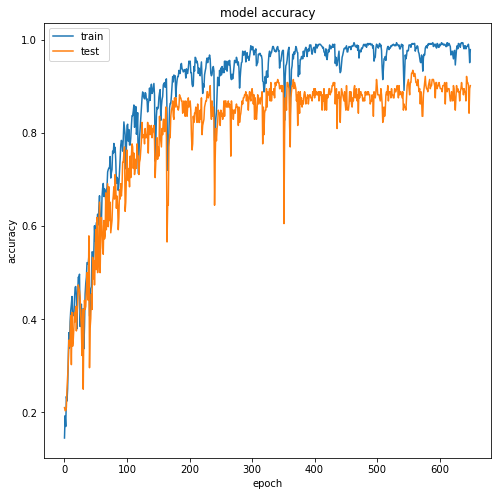

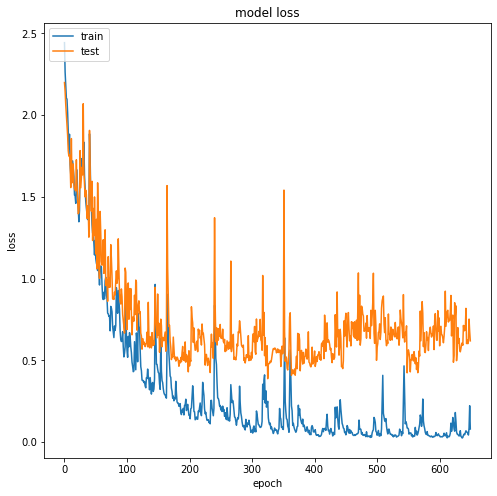

In [22]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 5.5 Model Summary

In [23]:
acm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  116800    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  135680    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
bidirectional_2 (Bidirection multiple                  98816     
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1

### 5.6 Accuracy on Test data

In [24]:
preds = acm_model.evaluate(x=X_test, y=Y_test)

print()
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

152/152 [==============================] - 2s 10ms/sample - loss: 0.6187 - accuracy: 0.9013

Loss = 0.6186892837285995
Test Accuracy = 0.9013158


### 5.7 Predict on Test data

In [25]:
# Predict on test set (X_test)
print("Shape of X_test:", X_test.shape)

Y_predict = acm_model.predict_classes(X_test)

print("Shape of Y_predict:", Y_predict.shape)
print("Shape of Y_test:", Y_test.shape)

# Convert back from one hot to single integer
Y_test = Y_test.argmax(axis=1)
print("Shape of Y_test (back from one-hot):", Y_test.shape)

Shape of X_test: (152, 96, 45)
Shape of Y_predict: (152,)
Shape of Y_test: (152, 15)
Shape of Y_test (back from one-hot): (152,)


## 6. View Cofusion Matrix on Test data

This is to see true preformance and to figure out how we can optimize training

In [26]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

confusion_matrix(Y_test, Y_predict)


array([[19,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 1, 23,  0,  1,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  0, 15,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0, 33,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 13,  1,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  3,  0,  0,  0,  0,  0,  0],
       [ 3,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1]], dtype=int64)

In [27]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    plt.rcParams["figure.figsize"] = (8,8)
    return ax


Unique labels are: [ 0.  1.  2.  3.  5.  7.  8.  9. 10. 11. 12. 14.]
Confusion matrix, without normalization
[[19  0  0  0  0  0  0  0  0  1  0  0]
 [ 1 23  0  1  0  0  3  0  0  0  0  0]
 [ 0  0 15  1  0  0  0  0  0  0  0  0]
 [ 1  0  0 33  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 13  1  1  0  0  0  0  0]
 [ 0  0  1  0  0  3  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  8  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1]]
Normalized confusion matrix
[[0.95       0.         0.         0.         0.         0.
  0.         0.         0.         0.05       0.         0.        ]
 [0.03571429 0.82142857 0.         0.03571429 0.         0.
  0.10714286 0.         0.         0.         0.         0.        ]
 [0.         0.         0.9375     0.0625     0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.028

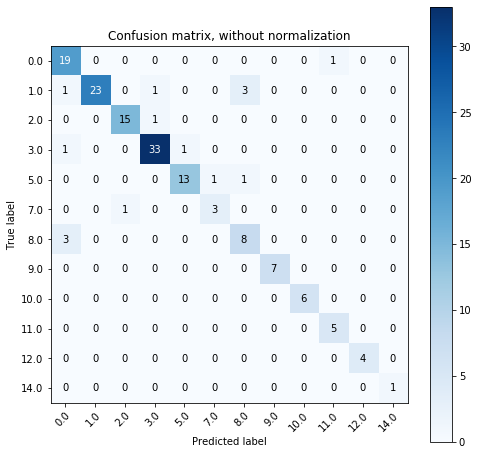

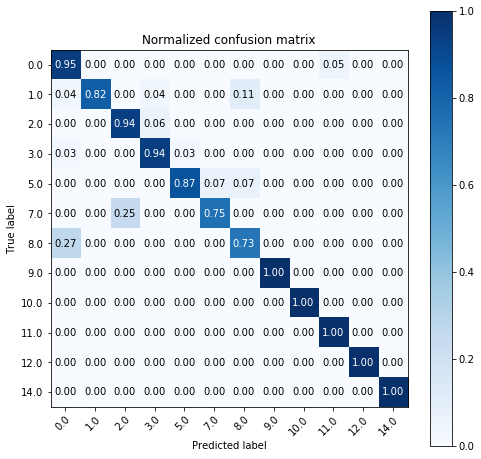

In [28]:
U = unique_labels(Y)
print("Unique labels are:", U)

# Call function to plot confusion matrix
plot_confusion_matrix(Y_test, Y_predict,U,normalize=False,title=None,cmap=plt.cm.Blues)
plot_confusion_matrix(Y_test, Y_predict,U,normalize=True,title=None,cmap=plt.cm.Blues)

print(""" 

0. "OK"
1. "The antenna is Unstable."
2. "Wet Snow."
3. "Affected by Rain." 

4. "Line of sight or Alignment problem." (Not used)
5. "Serious Line of sight or Alignment problem."
6. "Intermittent Line of sight problem." (Not used for now)

7. "The link is stuck on low modulation."

8. "Equipment problem." 

9. "Out of service detected."
10. "Limited data. Cannot do reliable predictions."
11. "A hardware restart was detected within this 24h period."

12. "The link is stuck on mid modulation."

13. "Time seq. missing. --> Automatically set in script at inference"

14. "Equipment fault (UAS)"

""")




# Save Model

In [47]:
acm_model.save_weights('model_output/Eband_Model_LSTM_96_24h_weights.h5')

acm_model.save ('model_output/Eband_Model_LSTM_96_24h.h5') # creates a HDF5 file


In [48]:
print("Training of Eband_Model_LSTM_96_24h is finished :) ")

Training of Eband_Model_LSTM_96_24h is finished :) 
